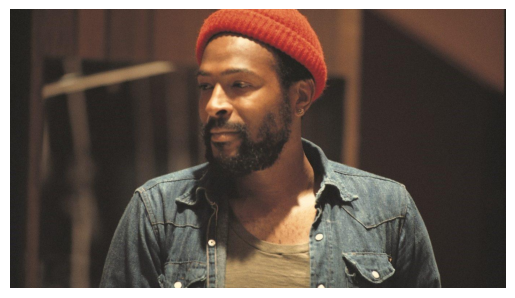

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import cv2
import math

# Defining quantization matrixes
quantization_matrix_y = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61],
                                [ 12, 12, 14, 19, 26, 28, 60, 55 ],
                                [ 14, 13, 16, 24, 40, 57, 69, 56 ],
                                [ 14, 17, 22, 29, 51, 87, 80, 62 ],
                                [ 18, 22, 37, 56, 68, 109, 103, 77 ],
                                [ 24, 35, 55, 64, 81, 104, 113, 92 ],
                                [ 49, 64, 78, 87, 103, 121, 120, 101 ],
                                [ 72, 92, 95, 98, 112, 100, 103, 99 ]]
                                )

quantization_matrix_c = np.array([[17,18,24,47,99,99,99,99],
                         [18,21,26,66,99,99,99,99],
                         [24,26,56,99,99,99,99,99],
                         [47,66,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99]])


Q = [quantization_matrix_y,quantization_matrix_c,quantization_matrix_c]

block_size = 8
channels=3
marvin = plt.imread('marvin.png')
marvin = np.uint8(np.array(marvin)*255)# from color map to rgb
plt.axis('off')
plt.imshow(marvin)

In [22]:
# conversion from rgb to YCBCR
def rgb_to_Ycbcr(image):
    
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = image.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)
# conversion from YCBCR to rgb
def ycbcr_to_rgb(image):
    
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = image.astype(float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)



# plotting data for different channels
def plot_ycbcr(image_to_plot):
    titles = ["Y","CB","CR"]
    plt.figure(figsize=(20,20))
    for channel in range(3):
        plt.subplot(3, 3,channel + 1 )
        plt.axis('off')
        plt.title(titles[channel])
        chroma = image_to_plot.copy()
        channels = [0,1,2]
        channels.remove(channel)
        chroma[:,:,channels] =   255/2
        rgb_im = ycbcr_to_rgb(chroma)
        plt.imshow( rgb_im )         

# Zig Zag crossing take an 8x8 matrix return an array
def zigzag(matrix):
    
    i = 0
    j = 0
    imin = 0
    jmin = 0
    imax = 8
    jmax = 8
    index = 0
    output = np.zeros(imax*jmax)

    while i < imax and j < jmax:
    
        if (i+j) % 2 == 0 :

            if i == imin :
                output[index] = matrix[i,j]
                j = j + 1

            elif (i != imin or i == imax - 1) and ( j != jmax -1 ):
                output[index] = matrix[i,j]
                i = i - 1 
                j = j + 1

            elif j == jmax - 1:
                output[index] = matrix[i,j] 
                i = i + 1
        else :

            if i == imin :
                output[index] = matrix[ i,j ]
                i = i + 1
                j = j - 1
            
            elif j == jmin and i != imax - 1 :
                output[index] = matrix[i,j]
                i = i + 1
            
            elif i == imax - 1 :
                output[index] = matrix[ i,j ]
                j = j + 1

            else :
                output[index] = matrix[i,j]
                i = i + 1
                j = j - 1
        
        index += 1

        if i == imax - 1 and j == jmax - 1 :
            output[index] = matrix[i,j]
            break
        
    return output

# Inverse Zig Zag take an array of 16 elements return a 8x8 matrix
def inverseZigZag(data):
    
    i = 0 
    j = 0 
    
    imax = 8
    jmax = 8
    
    imin = 0
    jmin = 0
    
    index = 0
    
    matrix = np.zeros((jmax,jmax))
    
    while i < imax and j < jmax :

        if (i + j )% 2 == 0:
            
            if i == imin: 
                matrix[i,j] = data[index]
                j = j+1
            
            elif (i != imin or i == imax -1) and ( j != jmax - 1 ):
                matrix[i,j] = data[index]
                i = i - 1
                j = j + 1
            
            elif j == jmax - 1:
                matrix[i,j] = data[index]
                i = i + 1
            
        else :
            
            if i == imin :
                matrix[i,j] = data[index]
                i = i + 1
                j = j - 1
                
            elif j == jmin and i != imax - 1 :
                matrix[i,j] = data[index]
                i = i + 1
            
            elif i == imax - 1:
                matrix[i,j] = data[index]
                j = j + 1
                
            else :
                matrix[i,j] = data[index]
                i = i + 1
                j = j - 1
                
        index +=1  
        
        if ( i == imax -1 ) and ( j == jmax - 1 ):
            matrix[i,j] = data[index]
            break
            
    return matrix 

In [23]:
def runLenghtEncode(data):
    skip = 0
    bitstream = []
    data = data.astype(int)
    bitstring = ""
    for index in range (data.shape[0] ):
        if data[index] !=0:
            bitstream.append((data[index],skip))
            bitstring = bitstring + str(data[index]) + " " + str(skip) + " "
            skip = 0
        else :
            skip = skip + 1
    return bitstring
            


In [24]:
# The Huffman Encoding process

# Class for a node of the tree 
# we have the symbol of the node 
# his left node and right node 
# the frequency of the node 
class HuffmanNode:
    
    def __init__( self ,probability ,symbol ,left = None , right = None ):
        self.probability = probability
        self.symbol = symbol
        self.left = left
        self.right = right
        self.code = ""

# Given the data (an array) we estimate 
# the frequency of each of our symbols
# return a dictionary with the symbol and 
# his frequency
def probabEstimate(data):
    local_symbol = dict()
            
    for elem in data :
            
        if local_symbol.get(elem) == None:
            local_symbol[elem] = 1
        else :
            local_symbol[elem] += 1
                
    return local_symbol

codes = dict()

# we get the code used for a specific symbol
# takes a node as input and crosses the Huffman 
# tree until it dosen't get the leaf
def getCodes(node,value = ""):
        
    new_val = value + str(node.code) 
        
    if node.left:
        getCodes(node.left,new_val)
        
    if node.right:
        getCodes(node.right,new_val)
        
    if not node.right and not node.left :
        codes[node.symbol] = new_val
        
    return codes

# we take the table of symbol and corresponding 
# code and the data we want to encode and return 
# the encoded information
def dataEncode(encodeTable,data):
    output = ""

    for elem in data :
        output+= encodeTable[elem]
    
    return output

# We pass the encode data 
# we take a byte of 0 and 1 of 
# the encoded data and convert it into
# hex ,return an array of hex
def byteConversion(data):
    b = bytearray()
    print(len(data))
    for index in range(0 , len(data), 8):
        b.append( int( data[index:index+8],2 ))  

    return b

# given the input data perform the Huffman encoding 
# and return a byte array and the Huffman tree
def huffmanEncoding(data):
    data = list(data) # converting input data into array
    frequency_data = probabEstimate(data)
    symbols = frequency_data.keys()
    frequencies = frequency_data.values()
    nodes = []
    #print(frequency_data)
    #print(symbols)

    
    for elem in symbols:
        nodes.append( HuffmanNode( frequency_data.get(elem),elem ) )
                     
    while len(nodes) > 1 :
        nodes = sorted( nodes, key = lambda  x : x.probability  )
         
        right = nodes[0]
        left = nodes[1]
        
        left.code = 0
        right.code = 1
        new_node = HuffmanNode( left.probability + right.probability ,str(left.symbol) + str(right.symbol) + "root"  , left , right )
        nodes.remove(left)
        nodes.remove(right)
        nodes.append(new_node)

    encoding = getCodes( nodes[0] )
    res = dataEncode( encoding,data )
    byte_data = byteConversion(res)
    #print(byte_data[0:100])
    
    
    return byte_data,nodes[0]

# Input : the encoded data and the Huffman tree
# we cross the the tree in order to find the actual 
# symbol for a given code , return the original symbols
def huffmanDecoding( encoding , tree ):
    encoding = list(encoding)
    head = tree
    output = []

    for elem in encoding :
        
        if elem == "0":
            tree = tree.left
        elif elem == "1":
            tree = tree.right
        
        if not tree.left and not tree.right:
            output.append(tree.symbol)
            tree = head
            
    return output
    #print(output)

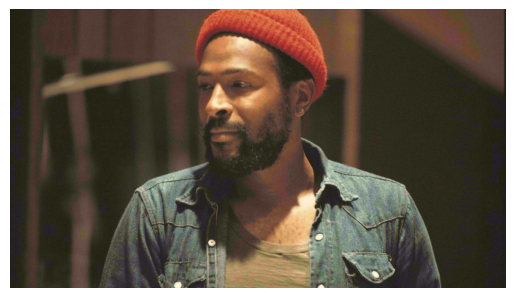

In [25]:
marvin_ycbcr = rgb_to_Ycbcr(marvin)
# Downsampling image for chrominance
down_image = marvin_ycbcr
#print(down_image[:3,:3,2])
down_image[:,:,1] = 10*np.round(down_image[:,:,1]/10)
down_image[:,:,2] = 10*np.round( down_image[:,:,2]/10 )
#print(down_image[:3,:3,2])
down_image = ycbcr_to_rgb(down_image)
plt.axis('off')
plt.imshow(down_image)

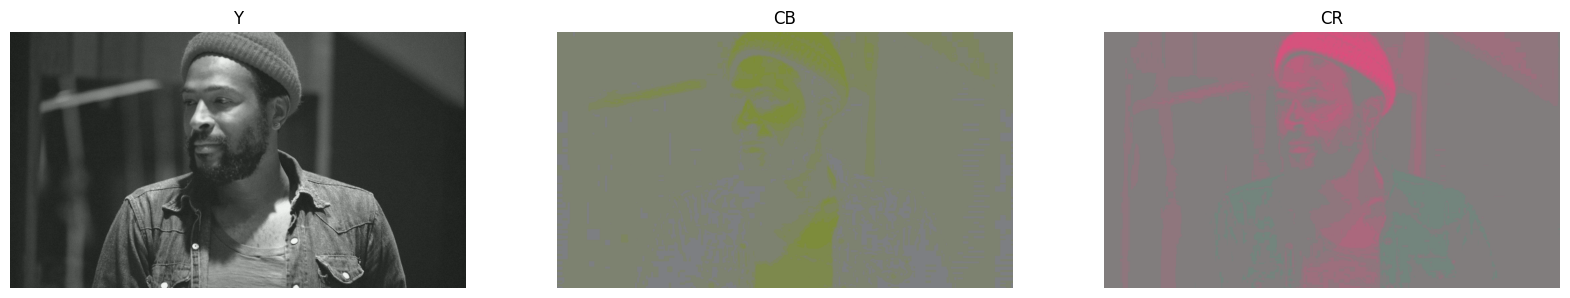

In [26]:
plot_ycbcr(marvin_ycbcr)

# Number of block we need
[h,w,i] = marvin_ycbcr.shape
num_blocks_h = math.ceil( h / block_size )
num_blocks_w = math.ceil( w / block_size )

# Create a padded image (and make it dividable by 8)
H = block_size * num_blocks_h
W = block_size * num_blocks_w

padded_image = np.zeros((H,W,3))
padded_image[:h,:w] = marvin_ycbcr[:h,:w]
data_compressed = np.zeros(H*W*3) 
index = 0

In [27]:
# Encoding process
for channel in range (channels):

    for index1 in range (num_blocks_h):
        row_begin = index1 * block_size
        row_end = row_begin + block_size

        for index2 in range (num_blocks_w):
            
            column_begin = index2 * block_size
            column_end = column_begin + block_size

            block = padded_image[ row_begin:row_end,column_begin:column_end,channel] # 8x8 block
            # We apply the DCT to each block
            DCT_block = cv2.dct(block)
            # We divide by the quantization matrix
            DCT_normalized = np.divide( DCT_block,Q[0] ).astype(int)
            resulting_block = zigzag(DCT_normalized)
            data_compressed[index : index + 64 ] =resulting_block
            index += 64
            #resulting_block = np.reshape(resulting_block,(block_size,block_size) )
            #padded_image[row_begin:row_end,column_begin:column_end,channel] = resulting_block
            

print(padded_image.shape)

(768, 1368, 3)


In [28]:
# now we can apply the encoding of our image 
#data = padded_image.flatten() # transforming into a list
# Huffman Encoding
data_stream,huffmanTree = huffmanEncoding(data_compressed)
# saving data into a binary file
raw_data = open("./raw_data/raw.bin","wb")
raw_data.write(data_stream)
raw_data.close()
print(len(data_stream))

3611340
451418


In [288]:
# Run Lenght Encoding
data_stream = runLenghtEncode(data)
# Now we add also some data about the size of our image for reconstruction
data_stream = str(padded_image.shape[0] ) +  " " + str(padded_image.shape[1])+ " " + data_stream + ";" 
#test_data =  data_stream.split() 
raw_data = open("./raw_data/raw.bin","w")
raw_data.write(data_stream)
raw_data.close()
print(len(data_stream))

453312


In [29]:
# Decoding Process - Huffman
image = []
# Reading byte by byte from file
with open('./raw_data/raw.bin',"rb") as raw_file:
        while (byte := raw_file.read(1)):
            image.append( byte )

data_from_file = ""

for element in image:  
    # converting hex into integer the into binary 
    # and recreating a byte length using zfill
    data_from_file += bin(int.from_bytes(element, byteorder='big'))[2:].zfill(8)

# Removing extra zeros
data_from_file = data_from_file[: len(data_from_file) - 4 ]
image_matrix = huffmanDecoding( data_from_file,huffmanTree )
index = 0

In [289]:
# Decoding Process - Run Lenght Encode
# Now we build our compressed image
with open('./raw_data/raw.bin',"r") as raw_file:
    image = raw_file.read()

data = image.split()
# we take the matrix dimesnsions
h = int(''.join(filter(str.isdigit, data[0])))
w = int(''.join(filter(str.isdigit, data[1])))
#print(data)
# begin of data 
i = 2
index = 0
j = 0

image_matrix = np.zeros(h*w*channels).astype(int)
# Now we can rebuild the image array
while index < image_matrix.shape[0]:
    
    if( data[i] == ';'):
        break
        
    
    if ("-" not in data[i]):
        image_matrix[index] = int("".join(filter(str.isdigit,data[i])))
    else:
        image_matrix[index] = -1 * int("".join(filter(str.isdigit,data[i])))

    if( i + 3 < len(data)):
        j = int("".join(filter(str.isdigit,data[i + 3])))
    
    if j == 0:
        index = index + 1
    else :
        index = index + 1 + j
    i = i + 2
# Now we must create the matrix for building the image
print(image_matrix.shape)
image_matrix = np.reshape(image_matrix,(h,w,channels))

(3151872,)


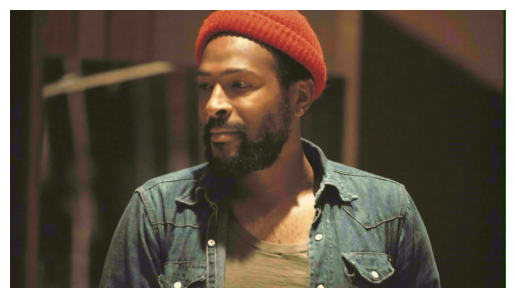

In [30]:
image_with_padding = np.zeros((padded_image.shape[0],padded_image.shape[1],channels))
#print(image_with_padding.shape,image_matrix.shape )
num_blocks_h = math.ceil( h / block_size )
num_blocks_w = math.ceil( w / block_size )
# Now we must prepare the compressed image
for channel in range( channels ):
    
    for index1 in range(num_blocks_h):
        row_begin = index1 * 8
        row_end = row_begin + 8
        
        for index2 in range(num_blocks_w):
            column_begin = index2 * 8
            column_end = column_begin + 8
            
            stream_data = image_matrix[ index:index + 64]
            index += 64
            block = inverseZigZag( stream_data ) # getting 8x8 block 
            de_quantized = np.multiply(block,Q[0])
            image_with_padding[row_begin:row_end ,column_begin : column_end,channel] = cv2.idct(de_quantized)
        
# converting to rgb
image_with_padding[image_with_padding>255] = 255
image_with_padding[image_with_padding<0] = 0

plt.axis("off")
plt.imshow(np.uint8(ycbcr_to_rgb( image_with_padding ) ))